# Aula 4

In [2]:
import numpy as np # NumPy for numerical operations
import matplotlib.pyplot as plt # Matplotlib for plotting
import cv2 # OpenCV for image processing

## Especificação de histogramas

### Minha implementação

In [3]:
img_input = cv2.imread('images/histograma_match1.jpg') # Load the input image
img_ref = cv2.imread('images/histograma_match2.jpg') # Load the reference image

chans_img = cv2.split(img_input) # separa os canais de cores
chans_ref = cv2.split(img_ref)   # separa os canais de cores

# iterage nos canais da imagem de entrada e calcula o histograma
pr = np.zeros((256, 3))
for chan, n in zip(chans_img, np.arange(3)):
    pr[:,n] = cv2.calcHist([chan], [0], None, [256], [0, 256]).ravel()

# iterage nos canais da imagem de referencia e calcula o histograma
pz = np.zeros((256, 3))
for chan, n in zip(chans_ref, np.arange(3)):
    pz[:,n] = cv2.calcHist([chan], [0], None, [256], [0, 256]).ravel()

# calcula as CDFs para a imagem de entrada
cdf_input = np.zeros((256, 3))
for i in range(3):
    cdf_input[:,i] = np.cumsum(pr[:,i]) # referencia

# calcula as CDFs para a imagem de referencia
cdf_ref = np.zeros((256,3))
for i in range(3):
    cdf_ref[:,i] = np.cumsum(pz[:,i]) # referencia

####################################################
# minha implementação do mapeamento de histogramas #
####################################################

# cria um array de mapeamento para cada canal
map_input = np.zeros((256, 3), dtype=np.uint8)

for i in range(3):
    for j in range(256):
        # encontra o valor mais proximo na CDF da imagem de referencia
        idx = np.argmin(np.abs(cdf_ref[:,i] - cdf_input[j,i]))
        map_input[j,i] = idx

# aplica o mapeamento na imagem de entrada
img_output = np.zeros_like(img_input)
for i in range(3):
    img_output[:,:,i] = map_input[img_input[:,:,i], i]


# exibe as imagens
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB))
plt.title('Imagem de Entrada')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB))
plt.title('Imagem de Referência')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))
plt.title('Imagem de Saída')
plt.axis('off')
plt.tight_layout()
plt.show() # Show the plots


[ WARN:0@0.032] global loadsave.cpp:268 findDecoder imread_('images/histograma_match1.jpg'): can't open/read file: check file path/integrity
[ WARN:0@0.032] global loadsave.cpp:268 findDecoder imread_('images/histograma_match2.jpg'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

### Implementação Linder

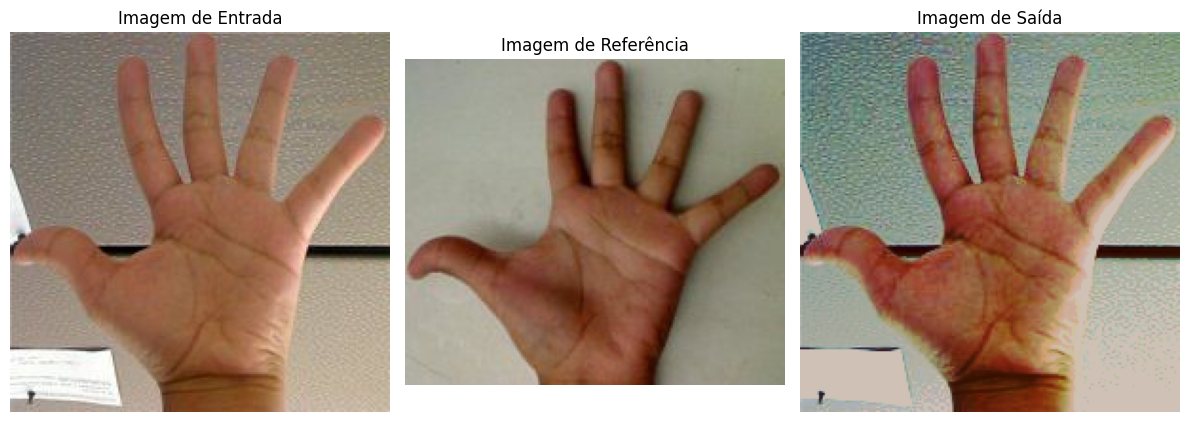

In [ ]:
img_input = cv2.imread('images/histograma_match1.jpg') # Load the input image
img_ref = cv2.imread('images/histograma_match2.jpg') # Load the reference image

chans_img = cv2.split(img_input) # separa os canais de cores
chans_ref = cv2.split(img_ref)   # separa os canais de cores

# iterage nos canais da imagem de entrada e calcula o histograma
pr = np.zeros((256, 3))
for chan, n in zip(chans_img, np.arange(3)):
    pr[:,n] = cv2.calcHist([chan], [0], None, [256], [0, 256]).ravel()

# iterage nos canais da imagem de referencia e calcula o histograma
pz = np.zeros((256, 3))
for chan, n in zip(chans_ref, np.arange(3)):
    pz[:,n] = cv2.calcHist([chan], [0], None, [256], [0, 256]).ravel()

# calcula as CDFs para a imagem de entrada
cdf_input = np.zeros((256, 3))
for i in range(3):
    cdf_input[:,i] = np.cumsum(pr[:,i]) # referencia

# calcula as CDFs para a imagem de referencia
cdf_ref = np.zeros((256,3))
for i in range(3):
    cdf_ref[:,i] = np.cumsum(pz[:,i]) # referencia

#################################################
# Linder's implementation of histogram matching #
#################################################


img_out = np.zeros(img_input.shape)

for c in range(3):
    for i in range(256):
        diff = np.absolute(cdf_ref[:,c] - cdf_input[i,c])
        indice = diff.argmin()
        img_out[img_input[:,:,c] == i, c] = indice

img_out = img_out.astype(np.uint8)

# iterage nos canais da imagem de saida e calcula o histograma
pa = np.zeros((256, 3))
# pa[:,0] = cv2.calcHist([img_out], [0], None, [256], [0, 256]).ravel()
# pa[:,1] = cv2.calcHist([img_out], [1], None, [256], [0, 256]).ravel()
# pa[:,2] = cv2.calcHist([img_out], [2], None, [256], [0, 256]).ravel()

img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB)
img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(img_input)
axs[0].set_title('Imagem de Entrada')
axs[0].axis('off')
axs[1].imshow(img_ref)
axs[1].set_title('Imagem de Referência')
axs[1].axis('off')
axs[2].imshow(img_out)
axs[2].set_title('Imagem de Saída')
axs[2].axis('off')
plt.tight_layout()
plt.show() # Show the plots


## Reamostragem de Imagens

### Reamostragem por Vizinho Mais Próximo

In [7]:
def resizeimg(img, sch, scw):
    """
    Redimensiona a imagem para as dimensões especificadas.
    
    :param img: Imagem de entrada (numpy array).
    :param sch: Nova altura da imagem.
    :param scw: Nova largura da imagem.
    :return: Imagem redimensionada.
    """
    h, w, c = img.shape # obtém as dimensões da imagem original (altura, largura, canais)

    # aloca a nova imagem
    nh = int(round(h * sch)) # calcula a nova altura
    nw = int(round(w * scw)) # calcula a nova largura
    newImg = np.zeros((nh, nw, c), dtype=np.uint8) # cria uma nova imagem com as dimensões especificadas

    # indices dos pixels da nova imagem
    Ro = np.arange(nh)
    Co = np.arange(nw)

    # Calcula os fatores de escala
    Sr = float(h) / float(nh) # fator de escala para a altura
    Sc = float(w) / float(nw) # fator de escala para a largura

    # Calcula o mapeamento dos indices
    Rm = Ro * Sr # mapeamento da altura
    Cm = Co * Sc # mapeamento da largura

    R = np.round(Rm).astype(int) # arredonda os indices da altura
    C = np.round(Cm).astype(int) # arredonda os indices da largura

    ### CORREÇÃO
    # Corrige índices fora do limite
    C[C >= w] = w - 1 # garante que os índices de largura não excedam o limite
    R[R >= h] = h - 1 # garante que os índices de altura não excedam o limite
    

    coord_new = [(x,y) for x in Ro for y in Co] # cria uma lista de tuplas com as coordenadas da nova imagem
    coord_ori = [(x,y) for x in R for y in C] # cria uma lista de tuplas com as coordenadas da imagem original

    for cn, co in zip(coord_new, coord_ori):
        newImg[cn] = img[co] # atribui o pixel da imagem original para a nova imagem
    
    return newImg # retorna a nova imagem redimensionada


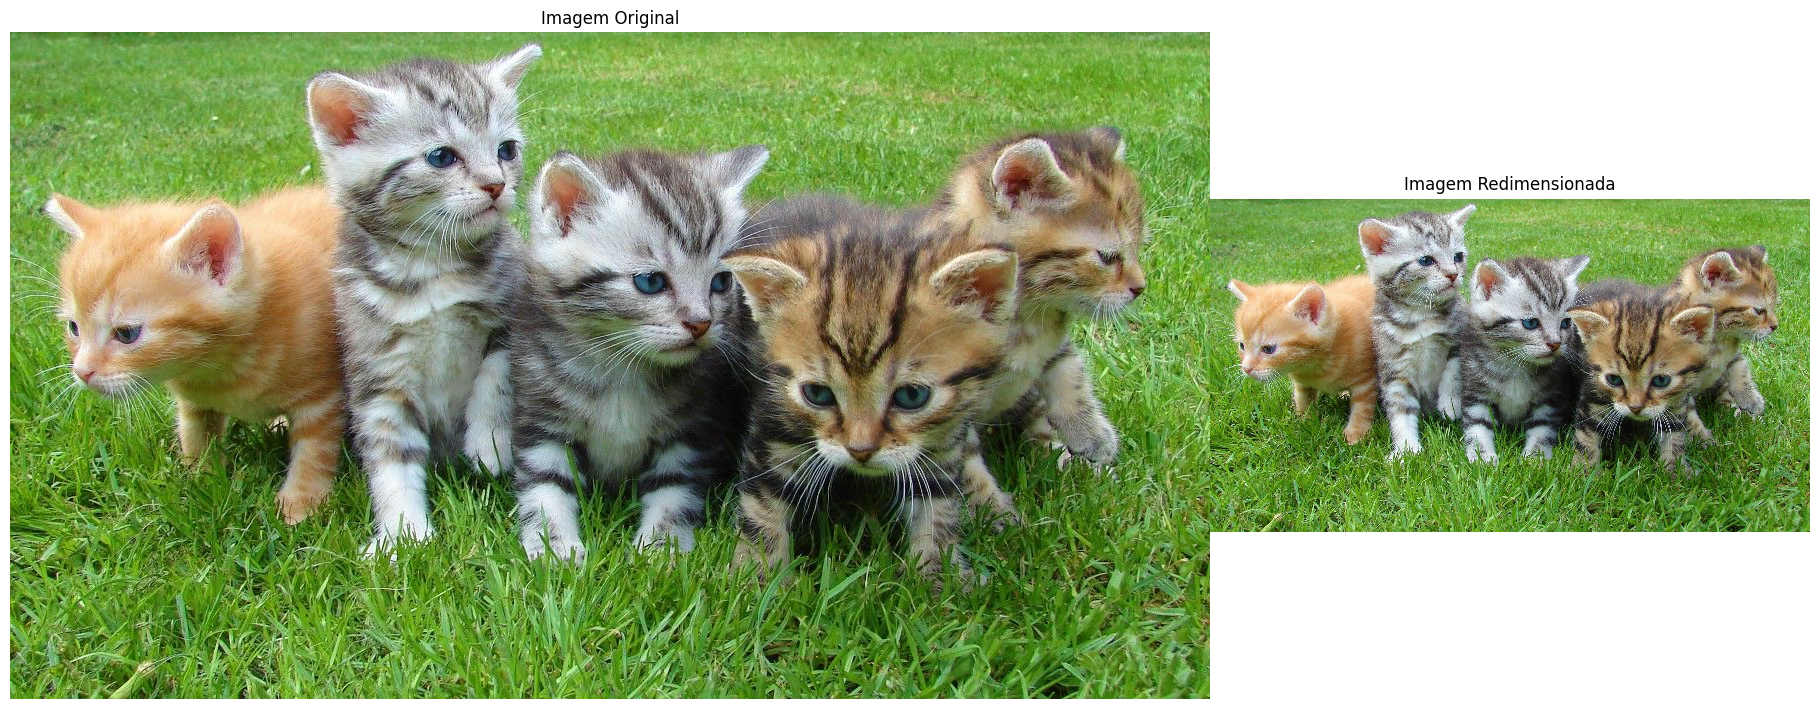

In [8]:
img = cv2.imread('images/gatinhos.jpg') # Load the input image

factor = 0.5 # Define the scaling factor

img_resized = resizeimg(img, factor, factor)

# Obtém as dimensões das imagens
h1, w1 = img.shape[:2]
h2, w2 = img_resized.shape[:2]
dpi = 100

# Calcula o tamanho total da figura em polegadas
fig_width = (w1 + w2) / dpi
fig_height = max(h1, h2) / dpi
fig = plt.figure(figsize=(fig_width, fig_height))

# Calcula as proporções de cada imagem
prop1 = w1 / (w1 + w2)
prop2 = w2 / (w1 + w2)

# Adiciona cada imagem em uma área proporcional
ax1 = fig.add_axes([0, 0, prop1, 1])
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Imagem Original')
ax1.axis('off')

ax2 = fig.add_axes([prop1, 0, prop2, 1])
ax2.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
ax2.set_title('Imagem Redimensionada')
ax2.axis('off')

plt.show()

### Reamostragem por interpolação bilinear

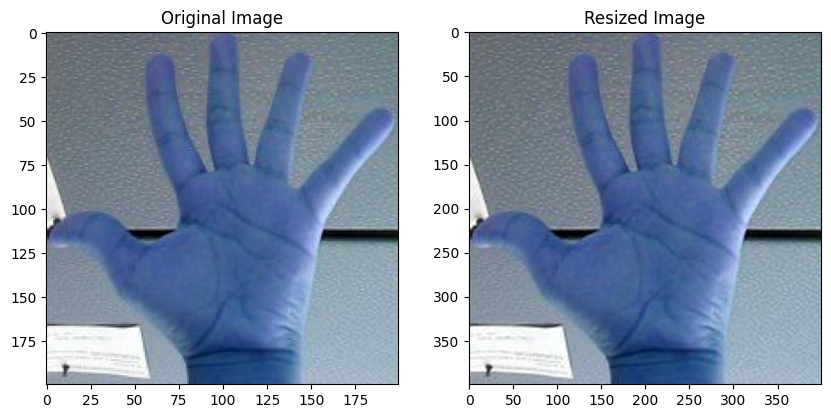

In [5]:
img = cv2.imread('./images/m2.jpeg')

l, c, canal = img.shape
w_nova = int(l * 2)
h_nova = int(c * 2)
img_nova = cv2.resize(img, (h_nova, w_nova), interpolation=cv2.INTER_CUBIC)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Original Image')
ax[0].imshow(img)
ax[1].set_title('Resized Image')
ax[1].imshow(img_nova)
plt.show()

# Filtragem

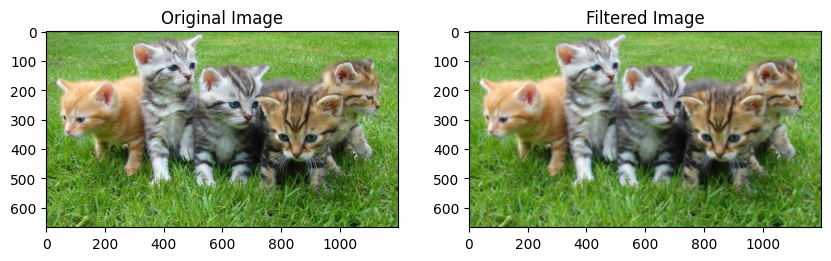

In [9]:
def getBoxKernel(size):
    kernel = np.ones((size, size)) 
    kernel = (1.0 / (size * size) ) * kernel  # Normaliza o kernel
    return kernel

img = cv2.imread('images/gatinhos.jpg') # Load the input image

box_kernel = getBoxKernel(5) # Define o tamanho do kernel
img_nova = cv2.filter2D(img, -1, box_kernel) # Ap

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converte a imagem para RGB
img_nova = cv2.cvtColor(img_nova, cv2.COLOR_BGR2RGB) # Converte a imagem filtrada para RGB

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Original Image')
ax[0].imshow(img)
ax[1].set_title('Filtered Image')
ax[1].imshow(img_nova)
plt.show() # Exibe as imagens filtradas